## Import section

In [1]:
import numpy as np
import json
import os
import seaborn as sns
import pandas as pd
from graphviz import Graph
import uuid
import tensorflow as tf
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed
from tensorflow.keras import Model

# Data Loading

In [2]:
os.getcwd()

'/home/jan/kaggle_competitions/covid'

In [3]:
raw_train_valid_ds = pd.read_json('./train.json', lines=True)
raw_test_ds = pd.read_json('./test.json', lines=True)
sample_submission = pd.read_csv('./sample_submission.csv')

In [4]:
raw_train_valid_ds.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
raw_test_ds.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [6]:
sample_submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [7]:
train_valid_example = raw_train_valid_ds.iloc[0,:]
print("TRAIN-VALID EXAMPLE")
print()
print(train_valid_example)

print('\n\n\n')

test_example = raw_test_ds.iloc[0,:]
print("TEST EXAMPLE")
print()
print(test_example)

TRAIN-VALID EXAMPLE

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167

In [8]:
feature_names = ['sequence', 'structure', 'predicted_loop_type']
error_label_names = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names = error_label_names + normal_label_names
important_label_names = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

In [9]:
print(f"sequence: {len(train_valid_example['sequence'])}")
print(f"structure: {len(train_valid_example['structure'])}")
print(f"predicted_loop_type: {len(train_valid_example['predicted_loop_type'])}")

print()

print(f"reactivity_error: {len(train_valid_example['reactivity_error'])}")
print(f"deg_error_Mg_pH10: {len(train_valid_example['deg_error_Mg_pH10'])}")
print(f"deg_error_pH10: {len(train_valid_example['deg_error_pH10'])}")
print(f"deg_error_Mg_50C: {len(train_valid_example['deg_error_Mg_50C'])}")
print(f"deg_error_50C: {len(train_valid_example['deg_error_50C'])}")

print()

print(f"reactivity: {len(train_valid_example['reactivity'])}")
print(f"deg_Mg_pH10: {len(train_valid_example['deg_Mg_pH10'])}")
print(f"deg_pH10: {len(train_valid_example['deg_pH10'])}")
print(f"deg_Mg_50C: {len(train_valid_example['deg_Mg_50C'])}")
print(f"deg_50C: {len(train_valid_example['deg_50C'])}")

sequence: 107
structure: 107
predicted_loop_type: 107

reactivity_error: 68
deg_error_Mg_pH10: 68
deg_error_pH10: 68
deg_error_Mg_50C: 68
deg_error_50C: 68

reactivity: 68
deg_Mg_pH10: 68
deg_pH10: 68
deg_Mg_50C: 68
deg_50C: 68


# Structured dataset construction

In [10]:
class LabelsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, labels):
        self.labels = labels

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns')
        return X

    def transform_example(self, example):
        for label in self.labels:
            example[label] = np.array(example[label], dtype=np.float32)
        return example

In [11]:
class FeaturesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.base2vec = {'A': [1,0,0,0],
                         'C': [0,1,0,0],
                         'G': [0,0,1,0],
                         'U': [0,0,0,1]}
        self.structpart2vec = {'.': [1,0,0],
                               '(': [0,1,0],
                               ')': [0,0,1]}
        self.looptype2vec = {'S': [1,0,0,0,0,0,0],
                             'M': [0,1,0,0,0,0,0],
                             'I': [0,0,1,0,0,0,0],
                             'B': [0,0,0,1,0,0,0],
                             'H': [0,0,0,0,1,0,0],
                             'E': [0,0,0,0,0,1,0],
                             'X': [0,0,0,0,0,0,1]}

    def fit(self, X, y=None, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        X = X.apply(self.transform_example, axis='columns', result_type='expand')
        return X

    def transform_example(self, example):
        encoded_sequence = [self.base2vec[base] for base in example['sequence']]
        example['sequence'] = encoded_sequence
        
        enocded_structure = [self.structpart2vec[structpart] for structpart in example['structure']]
        example['structure'] = enocded_structure
        
        enocded_loop_type = [self.looptype2vec[looptype] for looptype in example['predicted_loop_type']]
        example['predicted_loop_type'] = enocded_loop_type
        
        return example

In [12]:
def create_train_valid_ds(raw_train_valid_ds):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),              feature_names),
    (make_pipeline(LabelsEncoder(all_label_names)), all_label_names),
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_train_valid_ds))
    data.columns = feature_names + all_label_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        # features_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)
        features_dict[column] = tf.constant(values, dtype=tf.float32)

    labels_dict = data[all_label_names].to_dict(orient='list')
    for column, values in labels_dict.items():
        # labels_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)
        labels_dict[column] = tf.constant(values, dtype=tf.float32)

    # Create tf.data.Dataset
    train_valid_ds = tf.data.Dataset.from_tensor_slices((features_dict, labels_dict))

    return train_valid_ds

In [13]:
train_valid_ds = create_train_valid_ds(raw_train_valid_ds)

In [14]:
print('TRAIN-VALID DATASET')
print(train_valid_ds)
print('\n')
print('TRAIN-VALID DATASET EXAMPLE')
print(next(iter(train_valid_ds)))

TRAIN-VALID DATASET
<TensorSliceDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>


TRAIN-VALID DATASET EXAMPLE
({'sequence': <tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0.,

In [15]:
def create_test_ds(raw_test_ds):
    # Transform dataframe using encoders
    preprocessing = make_column_transformer(
    (make_pipeline(FeaturesEncoder()),feature_names)
    )

    data = pd.DataFrame(preprocessing.fit_transform(raw_test_ds))
    data.columns = feature_names

    # Split into features and labels and convert to dictionaries of tensors
    features_dict = data[feature_names].to_dict(orient='list')
    for column, values in features_dict.items():
        features_dict[column] = tf.ragged.constant(values, ragged_rank=1, inner_shape=None, dtype=tf.float32)

    # Create tf.data.Dataset
    test_ds = tf.data.Dataset.from_tensor_slices(features_dict)

    return test_ds

In [16]:
test_ds = create_test_ds(raw_test_ds)

In [17]:
print('TEST DATASET')
print(test_ds)
print('\n')
print('TEST DATASET EXAMPLE')
print(next(iter(test_ds)))

TEST DATASET
<TensorSliceDataset shapes: {sequence: (None, 4), structure: (None, 3), predicted_loop_type: (None, 7)}, types: {sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}>


TEST DATASET EXAMPLE
{'sequence': <tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0

# Raw example visualization

In [18]:
def retrive_connections(structure):
    open_indices = []
    connections = []
    for i, element in enumerate(structure):
        if element == '.':
            continue
        elif element == '(':
            open_indices.append(i)
        elif element == ')':
            connections.append((open_indices.pop(),i))
        else:
            raise "Incorrect structure"
    return connections

In [19]:
def create_graph(example):
    color_mapping = {'A': 'red', 'G': 'green', 'C': 'blue', 'U': 'yellow'}
    structure = example['structure']
    sequence = example['sequence']
    predicted_loop_type = example['predicted_loop_type']

    graph = Graph(engine='neato')
    graph.attr(rankdir="LR", size='20', overlap='false', sep='1', maxiter='99999999')
    
    graph.node(str(0), f"{sequence[0]}", style='filled', fillcolor=color_mapping[sequence[0]])
    for i in range(1, len(structure)):
        graph.node(str(i), f"{sequence[i]}", style='filled', fillcolor=color_mapping[sequence[i]])
        graph.edge(str(i-1), str(i))
    
    additional_connections = retrive_connections(structure)
    for x, y in additional_connections:
        graph.edge(str(x), str(y))
    return graph   

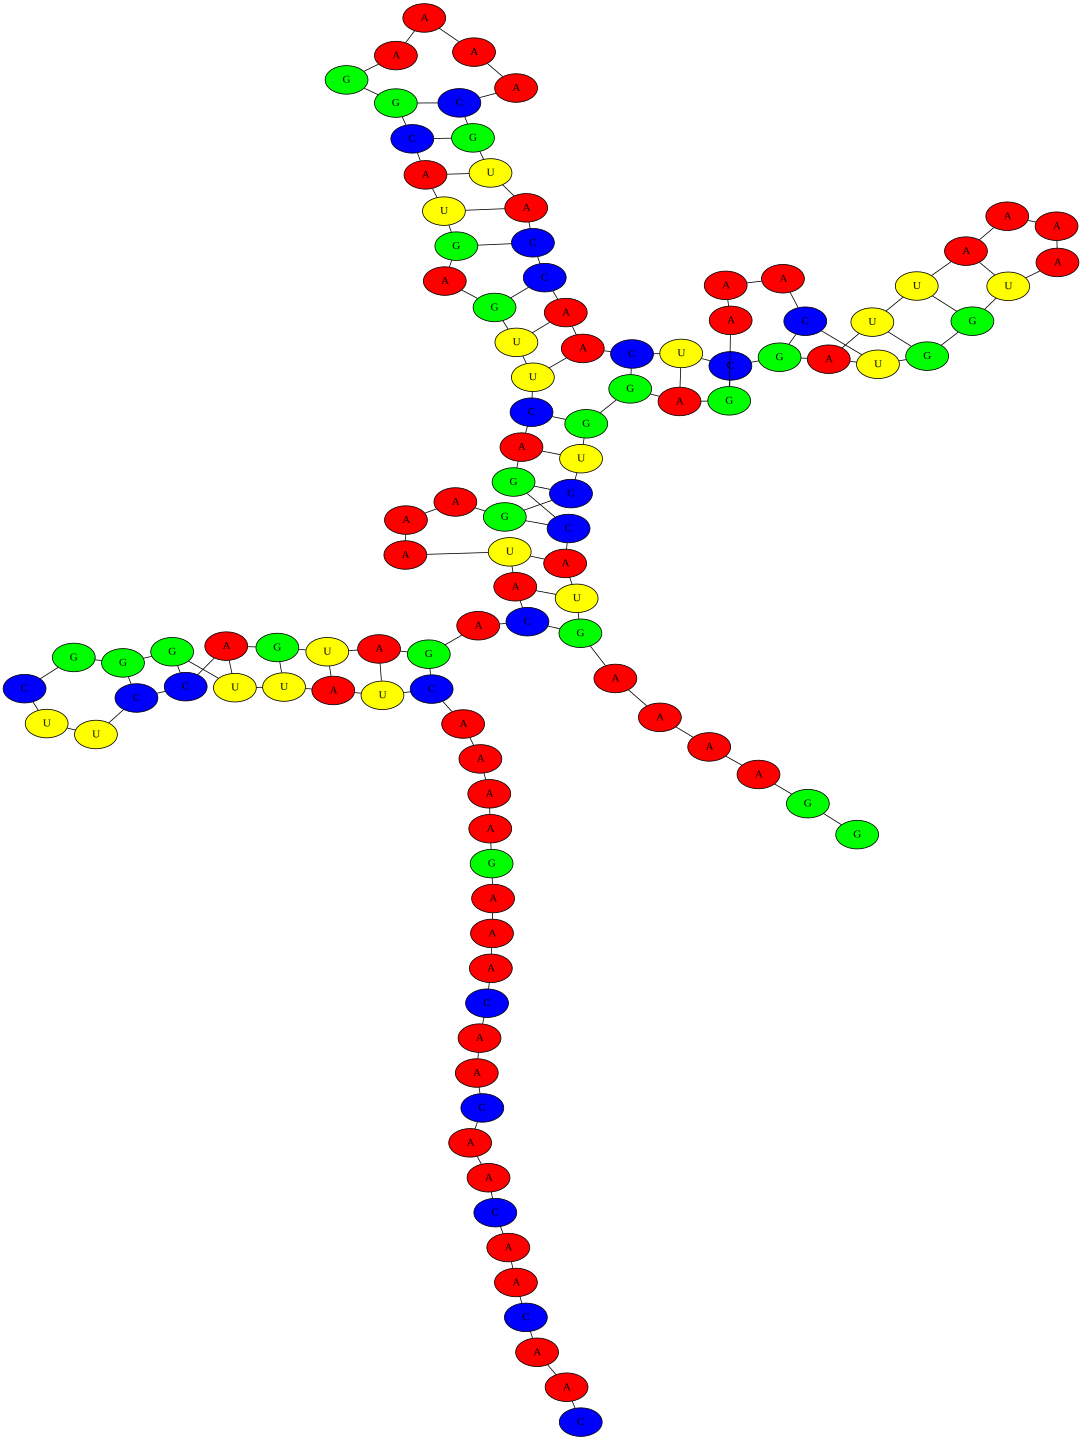

In [20]:
create_graph(raw_test_ds.iloc[0,:])

# Model

In [21]:
print(f"feature_names: {feature_names}")
print(f"error_label_names: {error_label_names}")
print(f"normal_label_names: {normal_label_names}")
print(f"all_label_names: {all_label_names}")
print(f"important_label_names: {important_label_names}")

feature_names: ['sequence', 'structure', 'predicted_loop_type']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
important_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


In [22]:
class MyDecoderLSTM(LSTM):
    def __init__(self, units, output_sequence_length, **kwargs):
        self.output_sequence_length = output_sequence_length
        super().__init__(units, **kwargs)

    def call(self, inputs, **kwargs):
        # print(type(inputs))
        # BATCH_SIZE = inputs[0].shape[0]
        # print(f"BATCH_SIZE: {BATCH_SIZE}")
        BATCH_SIZE = 32
        inputs = tf.zeros((BATCH_SIZE, self.output_sequence_length, 14))
        return super().call(inputs, **kwargs)

In [48]:
# INPUTS
INPUT_SEQUENCE_LEANGTH = None
sequence_input = Input(shape=(INPUT_SEQUENCE_LEANGTH,4),
                       name='sequence')
structure_input = Input(shape=(INPUT_SEQUENCE_LEANGTH,3),
                        name='structure')
predicted_loop_type_input = Input(shape=(INPUT_SEQUENCE_LEANGTH,7),
                                  name='predicted_loop_type')

inputs = [sequence_input, structure_input, predicted_loop_type_input]

# ACTUAL MODEL
# Stack inputs
stacked_inputs = tf.keras.layers.Concatenate(axis=2, name='Stacking_layer')(inputs)

# Cast to tensors
# cast_layer = tf.keras.layers.Lambda(lambda x: x.to_tensor(shape=(None, 14)))
# stacked_inputs = cast_layer(stacked_inputs)

# Encoder
encoder_LSTM = LSTM(128, return_state=True, name='encoder_LSTM')
_, state_h, state_c = encoder_LSTM(stacked_inputs)

# Decoder
decoder_LSTM = MyDecoderLSTM(128, 68, return_sequences=True, name='decoder_LSTM')
decoder_outputs = decoder_LSTM(stacked_inputs, initial_state=[state_h, state_c])

# Dense layers
x = TimeDistributed(Dense(256, activation='relu', name='Dense_1'))(decoder_outputs)
x = TimeDistributed(Dense(256, activation='relu', name='Dense_2'))(x)

# OUTPUTS
reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
reactivity_error_pred = TimeDistributed(Dense(1), name='reactivity_error')(x)

deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
deg_error_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_error_Mg_pH10')(x)

deg_pH10_pred = TimeDistributed(Dense(1), name='deg_pH10')(x)
deg_error_pH10_pred = TimeDistributed(Dense(1), name='deg_error_pH10')(x)

deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)
deg_error_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_error_Mg_50C')(x)

deg_50C_pred = TimeDistributed(Dense(1), name='deg_50C')(x)
deg_error_50C_pred = TimeDistributed(Dense(1), name='deg_error_50C')(x)


outputs = [reactivity_pred, reactivity_error_pred,
           deg_Mg_pH10_pred, deg_error_Mg_pH10_pred,
           deg_pH10_pred, deg_error_pH10_pred,
           deg_Mg_50C_pred, deg_error_Mg_50C_pred,
           deg_50C_pred, deg_error_50C_pred]

model = Model(inputs, outputs)

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
structure (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
predicted_loop_type (InputLayer [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
Stacking_layer (Concatenate)    (None, None, 14)     0           sequence[0][0]                   
                                                                 structure[0][0]       

In [24]:
@tf.function()
def MCRMSE(yTrue, yPred, name='MCRMSE'):
  # TODO
    pass

In [50]:
model.compile(loss={'reactivity': 'mse',
                    'deg_Mg_pH10': 'mse',
                    'deg_Mg_50C': 'mse'
                    },
              optimizer='adam')

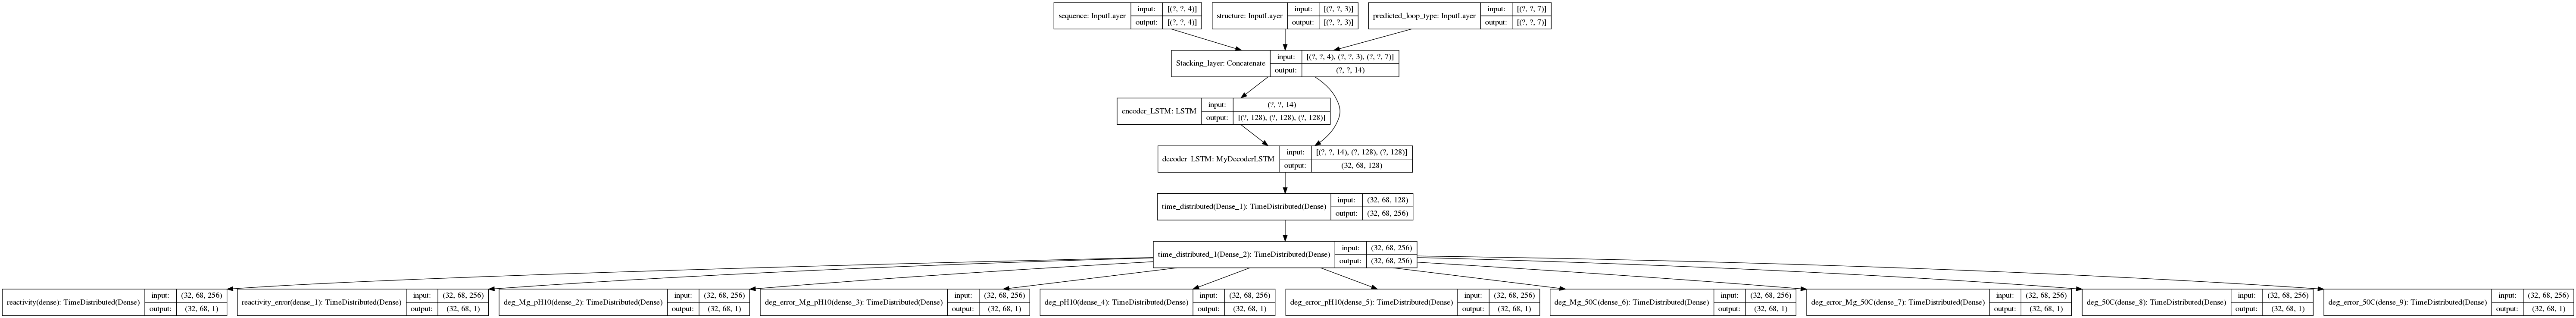

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
class SelectLabels:
    def __init__(self, choosen_label_names):
        self.choosen_label_names = choosen_label_names

    def __call__(self, x, y):
        y = {label_name: y[label_name] for label_name in self.choosen_label_names}
        return x, y

In [28]:
class SelectFeatures:
    def __init__(self, choosen_feature_names):
        self.choosen_feature_names = choosen_feature_names

    def __call__(self, x, y):
        x = {feature_name: x[feature_name] for feature_name in self.choosen_feature_names}
        return x, y

In [29]:
exp_ds = train_valid_ds.map(SelectFeatures(['sequence'])).map(SelectLabels(['reactivity']))

In [30]:
exp_ds

<MapDataset shapes: ({sequence: (107, 4)}, {reactivity: (68,)}), types: ({sequence: tf.float32}, {reactivity: tf.float32})>

In [40]:
train_valid_ds

<TensorSliceDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>

In [32]:
lenght = train_valid_ds.cardinality().numpy()
SPLIT_FACTOR = 0.30
valid_ds_length = int(SPLIT_FACTOR*lenght)
train_valid_ds_shuffled = train_valid_ds.shuffle(lenght)
train_ds = train_valid_ds_shuffled.skip(valid_ds_length)
valid_ds = train_valid_ds_shuffled.take(valid_ds_length)

In [44]:
print(train_ds.cardinality())
print(train_ds)

tf.Tensor(1680, shape=(), dtype=int64)
<SkipDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>


In [43]:
print(valid_ds.cardinality())
print(valid_ds)

tf.Tensor(720, shape=(), dtype=int64)
<TakeDataset shapes: ({sequence: (107, 4), structure: (107, 3), predicted_loop_type: (107, 7)}, {reactivity_error: (68,), deg_error_Mg_pH10: (68,), deg_error_pH10: (68,), deg_error_Mg_50C: (68,), deg_error_50C: (68,), reactivity: (68,), deg_Mg_pH10: (68,), deg_pH10: (68,), deg_Mg_50C: (68,), deg_50C: (68,)}), types: ({sequence: tf.float32, structure: tf.float32, predicted_loop_type: tf.float32}, {reactivity_error: tf.float32, deg_error_Mg_pH10: tf.float32, deg_error_pH10: tf.float32, deg_error_Mg_50C: tf.float32, deg_error_50C: tf.float32, reactivity: tf.float32, deg_Mg_pH10: tf.float32, deg_pH10: tf.float32, deg_Mg_50C: tf.float32, deg_50C: tf.float32})>


In [ ]:
history = model.fit(train_valid_ds.batch(32),
          epochs=100)
# model.fit(train_ds.batch(32),
#           validation_data=valid_ds.batch(32),
#           epochs=100)

In [52]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets
